In [6]:
# Extract from https://github.com/StanfordVL/behavior/blob/main/behavior/benchmark/behavior_benchmark.py
import os
import bddl
import json
import copy
import behavior
import pyquaternion  
import numpy as np
import pybullet as p
#np.random.seed(3)

from PIL import Image
from igibson.utils.utils import parse_config
from igibson.envs.igibson_env import iGibsonEnv
from igibson import object_states
from igibson.action_primitives.starter_semantic_action_primitives import StarterSemanticActionPrimitives

from utils import get_env_config, teleport_near_obj, print_properties
from primitives_utils import get_names_of_visible_obj_inside, open_or_close, make_object_visible_inside_container, get_objects_inside, settle_physics 
import render_utils

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
scene_id =  "Benevolence_1_int"
task = "cleaning_out_drawers"
env_config = get_env_config()
env_config["scene_id"] = scene_id
env_config["task"] = task
env_config["task_id"] = 0
env_config["instance_id"] = 0

# Keep this in memory as it's removed from the config when we init iGibson - so we need to reload it
robot_name = env_config["robot"]["name"]

env = iGibsonEnv(
        config_file=env_config,
        mode="headless",
        action_timestep=1.0 / 30.0,
        physics_timestep=1.0 / 120.0,
    )

#render_utils.render_frame(env, show=True, save=False)
settle_physics(env)
    
#render_utils.render_frame(env, show=False, save=True)
#render_utils.render_robot_eye_pov(env)

Rendering settings is None - going with the default settings!
																																																																						b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
left_hand_shoulderb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
right_hand_shoulderb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
neckb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data

## Navigate to obj

The StarterSemanticActionPrimitive is a work-in-progress and is only provided as an example. It currently only works with BehaviorRobot with its JointControllers set to absolute mode. See provided behavior_robot_mp_behavior_task.yaml config file for an example. See examples/action_primitives for runnable examples.


                                                      
Attempt: 0
                                                        Candidate position failed shoulder distance test.
                                                      
Attempt: 1
                                                          Start collision test.
                                                          Body has collision with objects %s [28]
                                                          Right hand has collision with objects %s [24]
                                                          End collision test.
                                                        Candidate position failed collision test.
                                                      
Attempt: 2
                                                          Start collision test.
                                                          End collision test.


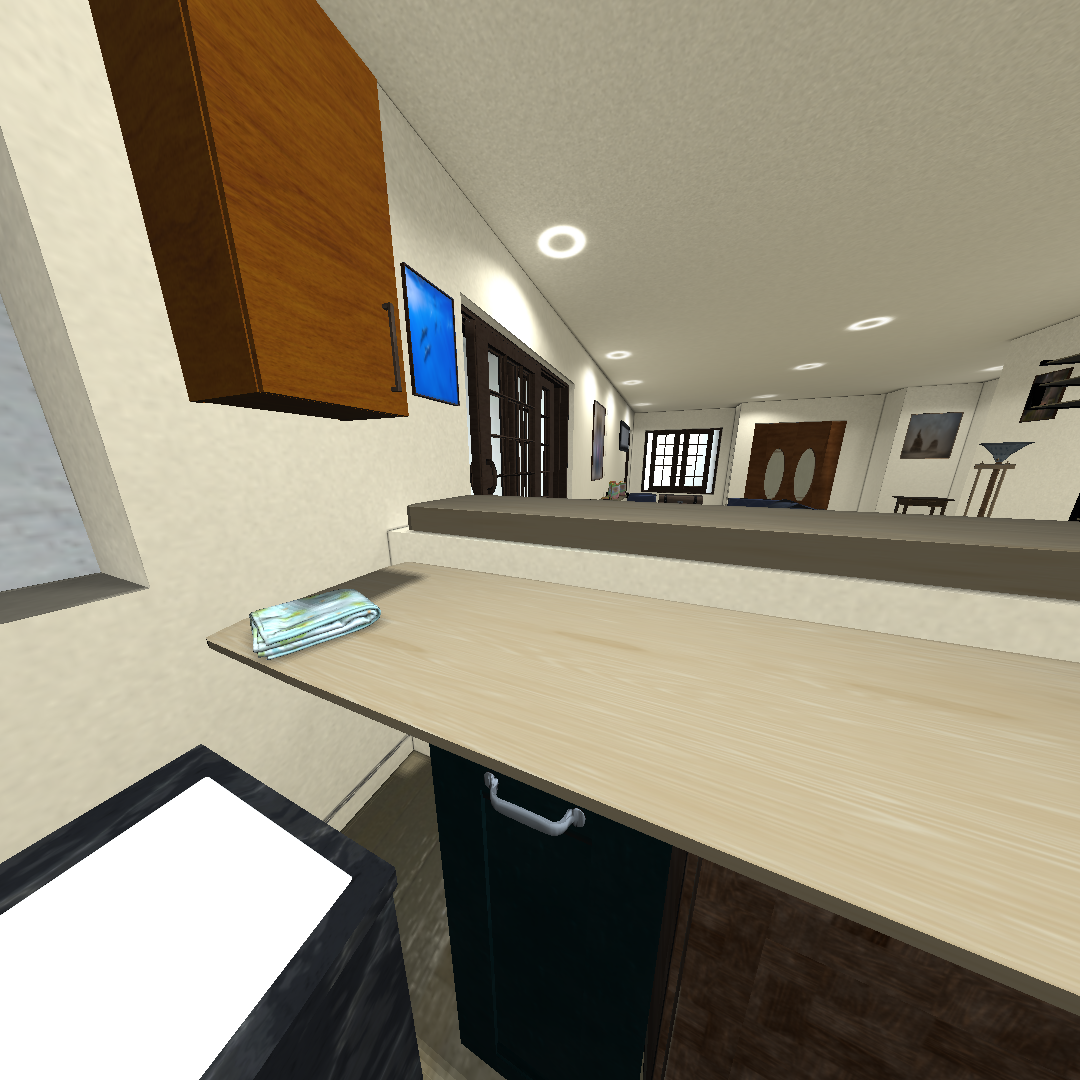

In [7]:
scene = env.scene
s = env.simulator
robot = env.robots[0]
controller = StarterSemanticActionPrimitives(None, scene, robot)

#container_obj = env.task.object_scope['sink.n.01_1']
#container_obj = env.task.object_scope['cabinet.n.01_1'] 
container_obj = env.task.object_scope['cabinet.n.01_2']

# Show before
#render_utils.render_frame(env, show=True, save=True, name='before')
#print_properties(container_obj)
teleport_near_obj(controller, container_obj, env)

settle_physics(env)
    
render_utils.render_frame(env, show=True, save=True, name='after_look_forward')
#render_utils.render_frame_with_trg_obj(env, container_obj, show=True, save=True, add_obj_center=True, name='after_look_center')
#render_utils.render_frame_with_trg_obj(env, container_obj, show=True, save=True, add_bbox=True, name='after_look_3d_bbox')
#print_properties(container_obj)

In [8]:
# Sanity check to see which phase is the front one
#render_utils.render_frame_with_trg_obj(env, container_obj, show=True, save=True, add_contour_points=True, name='after_frontal_face_highlighted')

# Quite informative about what's inside a generic class object
#for attr, value in vars(obj).items():
#    print(f"{attr}: {value}")

In [10]:
name, obj2 = get_names_of_visible_obj_inside(env, container_obj)

spoon.n.01_1 is NOT colliding with the container
spoon.n.01_1 is inside cabinet.n.01_2
spoon.n.01_1 is visible: False
spoon.n.01_2 is NOT colliding with the container
spoon.n.01_2 is inside cabinet.n.01_2
spoon.n.01_2 is visible: False
No visible object inside!


cabinet.n.01_2 is open: False
cabinet.n.01_2 is open: True


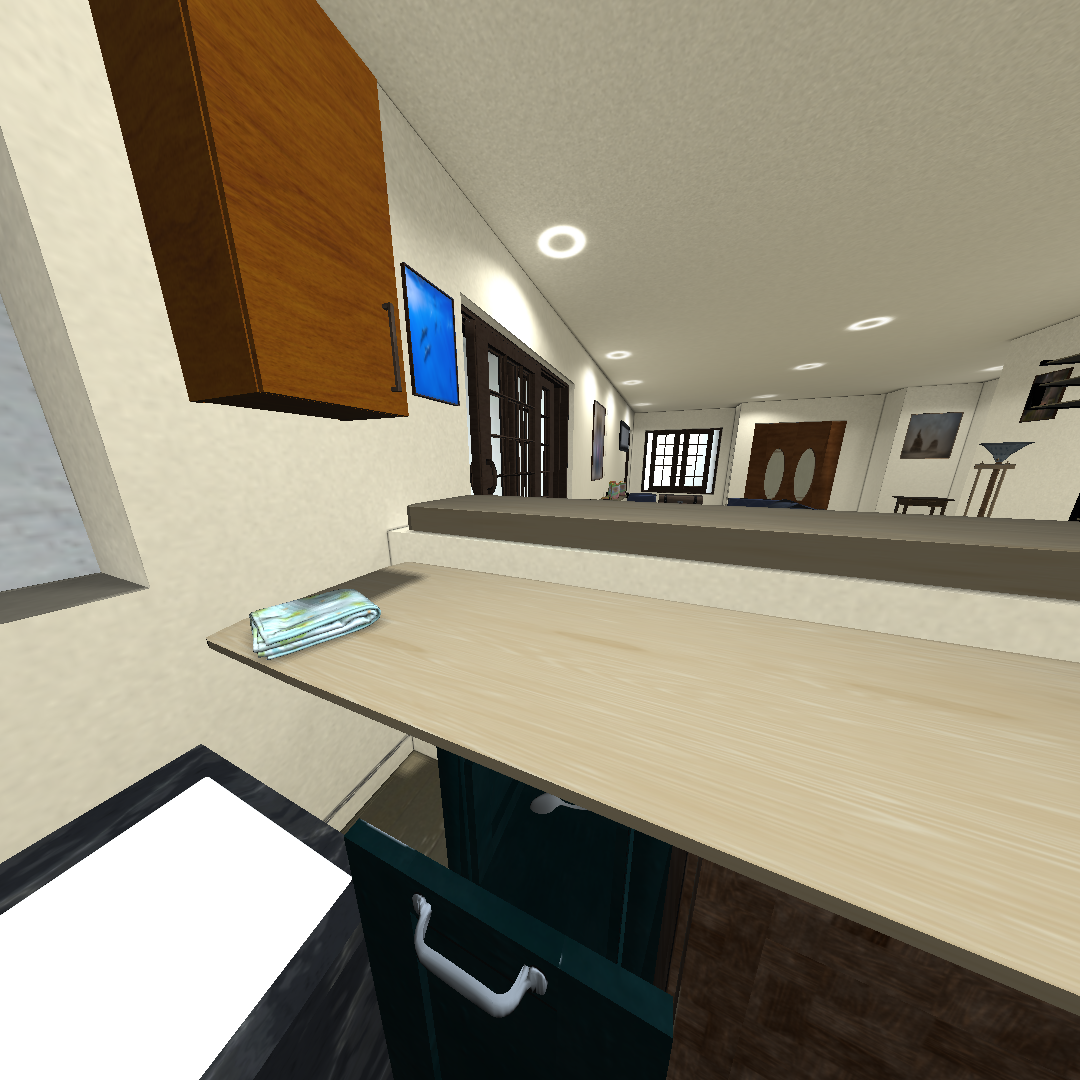

In [13]:
open_or_close(env, container_obj)
render_utils.render_frame(env, show=True, save=True, name='after_open', field_of_view=120)
#render_utils.render_robot_eye_pov(env, show=True, save=True, name='after_open_robot_eyes')

In [14]:
name, obj2 = get_names_of_visible_obj_inside(env, container_obj)

spoon.n.01_1 is NOT colliding with the container
spoon.n.01_1 is inside cabinet.n.01_2
spoon.n.01_1 is visible: False
spoon.n.01_2 is NOT colliding with the container
spoon.n.01_2 is inside cabinet.n.01_2
spoon.n.01_2 is visible: True

spoon.n.01_2 is visible: True


In [ ]:
render_utils.render_frame_with_trg_obj(env, obj2, show=True, save=True, add_obj_center=True, name='after_look_center')
render_utils.render_frame_with_trg_obj(env, obj2, show=True, save=True, add_bbox=True, name='after_look_3d_bbox')

### Make all objects inside visible

In [15]:
# What possible strategies are there?
# Sample positions of the object within the volume of the container
# Check that is both inside and visible both before and after the physics settles
# It's very likely that the sampling will let objects fall on the bottom of the surface before stopping -> we can check step-by-step

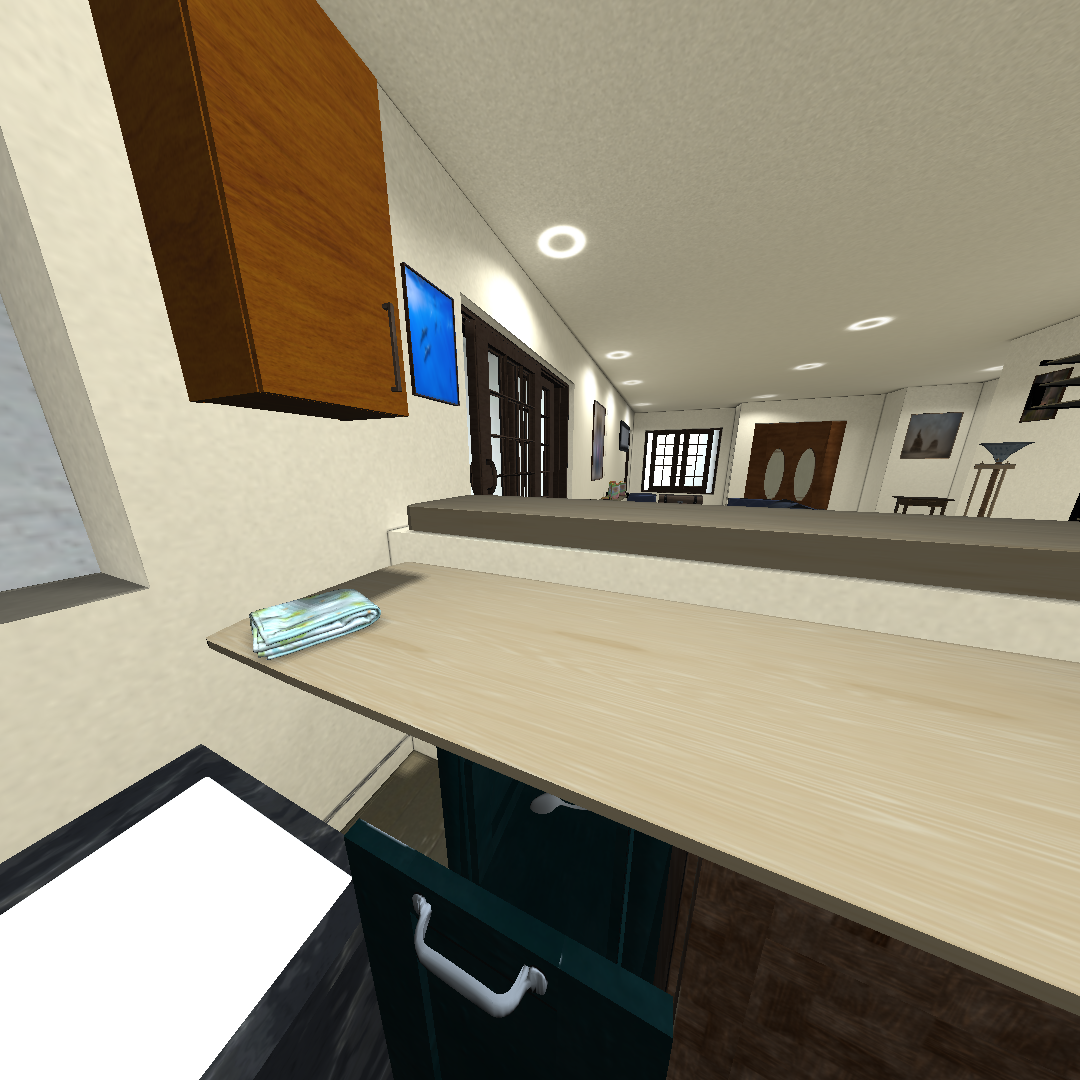

The StarterSemanticActionPrimitive is a work-in-progress and is only provided as an example. It currently only works with BehaviorRobot with its JointControllers set to absolute mode. See provided behavior_robot_mp_behavior_task.yaml config file for an example. See examples/action_primitives for runnable examples.


Name: spoon.n.01_1

Contact distance of penetration point:  -0.0001276909779573753

Contact distance of penetration point:  -0.0015159761701187067

Contact distance of penetration point:  -0.002808790241343686

Contact distance of penetration point:  -0.0010141659943228973

Contact distance of penetration point:  -0.00633047948531706

Contact distance of penetration point:  -0.001961744508897203

Contact distance of penetration point:  -0.01959594999146069

Contact distance of penetration point:  -0.01854931900945577
Success: True
Object successfully moved to a visible position inside the container
Distance from shoulder: 0.6493261183509685


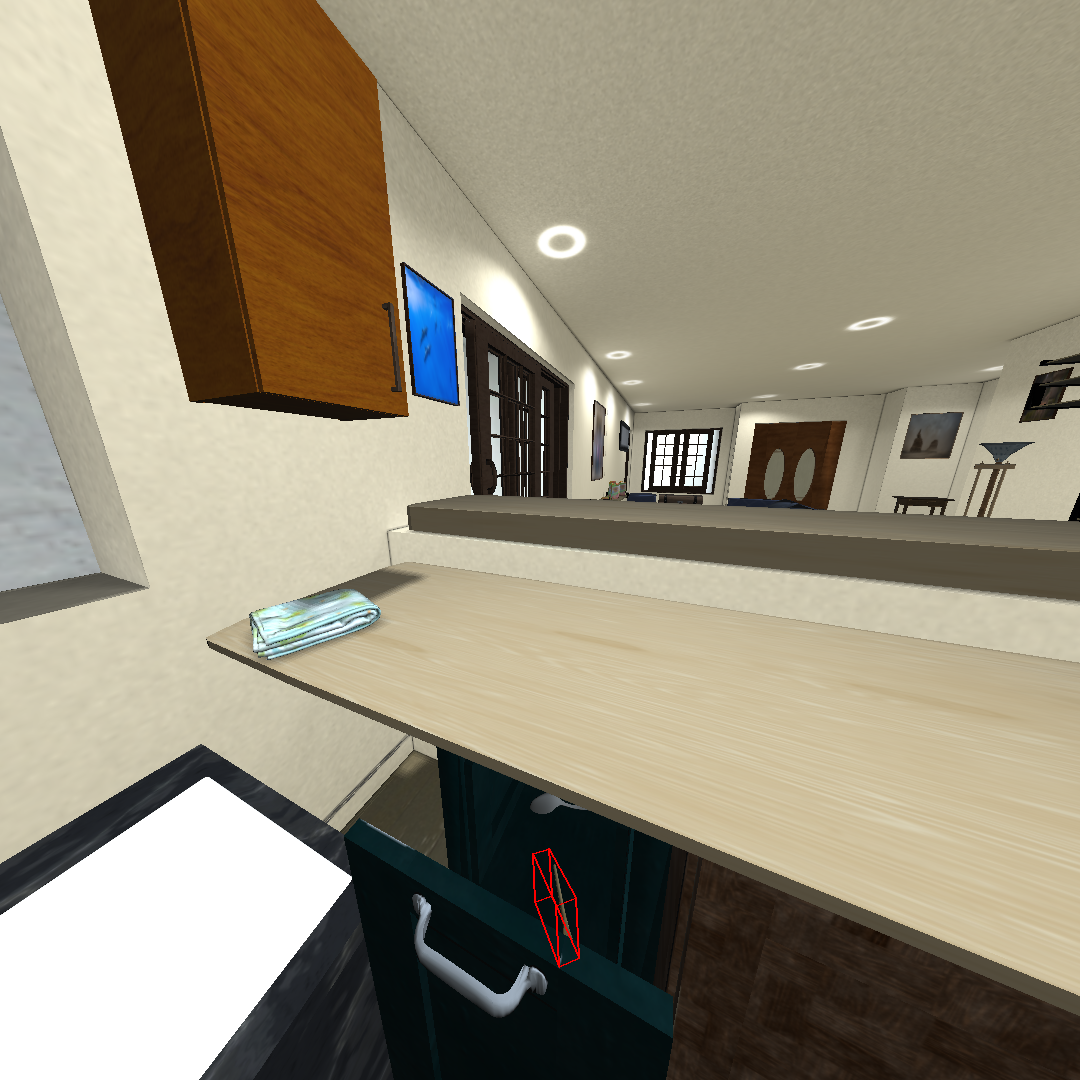

The StarterSemanticActionPrimitive is a work-in-progress and is only provided as an example. It currently only works with BehaviorRobot with its JointControllers set to absolute mode. See provided behavior_robot_mp_behavior_task.yaml config file for an example. See examples/action_primitives for runnable examples.


Name: spoon.n.01_2
Success: True
Target object is already inside the container and visible
Distance from shoulder: 0.7802917694933083


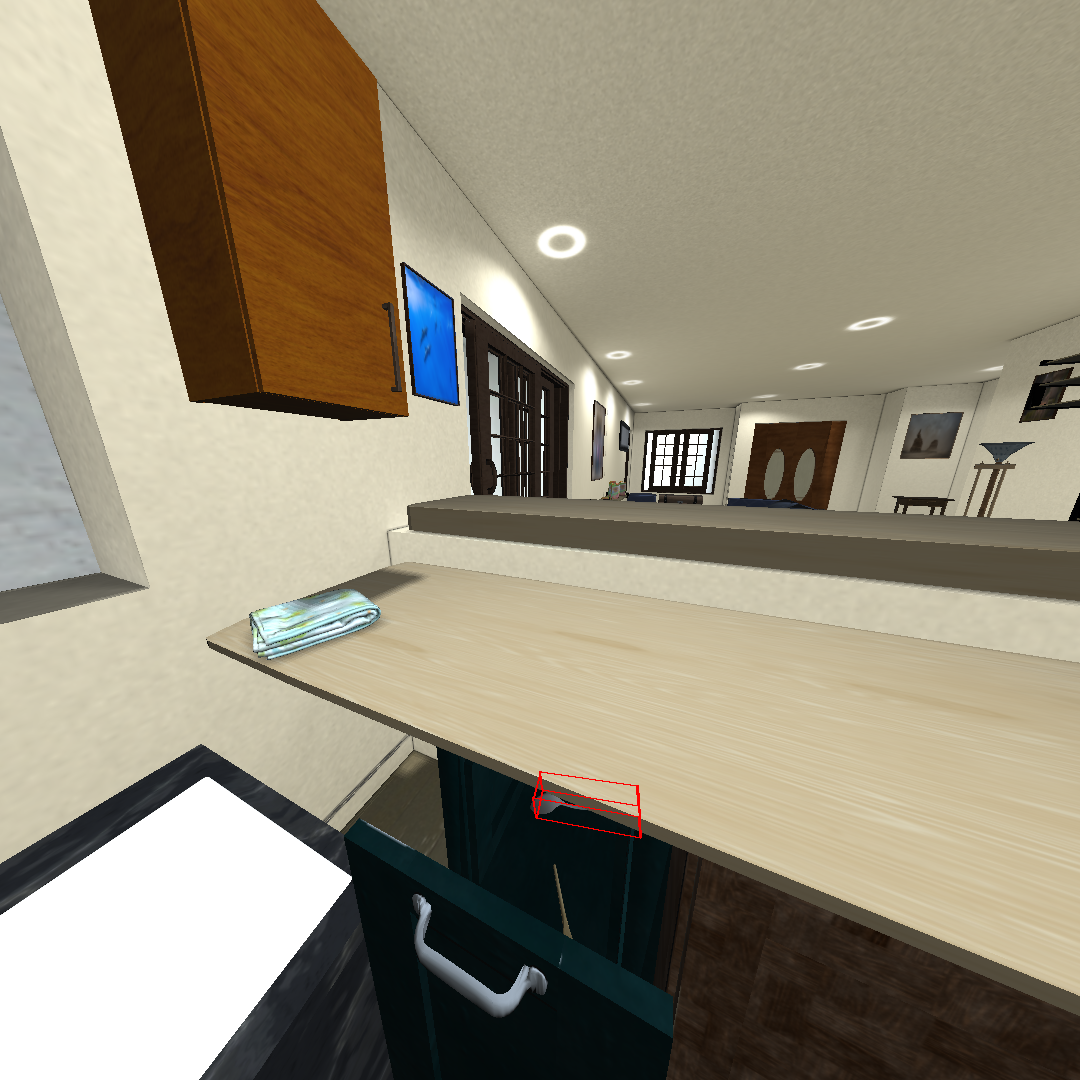

In [18]:
# Render starting point
render_utils.render_frame(env, show=True, save=True, name='before_rearrangement')

# Get list of objects inside the container_obj
names, objects = get_objects_inside(env, container_obj)
    
# For every object inside the container, apply the function and render the state after the function call
for name, trg_obj in zip(names, objects):
    print(f"Name: {name}")
    success, info = make_object_visible_inside_container(env, trg_obj, container_obj, sampling_budget = 200, physics_steps=30, max_distance_from_shoulder=1.0)
    distance_from_shoulder = controller._get_dist_from_point_to_shoulder(trg_obj.get_position())
    print(f"Success: {success}")
    print(info)
    print(f"Distance from shoulder: {distance_from_shoulder}")
    if success:
        render_utils.render_frame_with_trg_obj(env, trg_obj, show=True, save=True, add_bbox=True, name=f'after_rearranging_{name}')

In [19]:
name, obj2 = get_names_of_visible_obj_inside(env, container_obj)

spoon.n.01_1 is NOT colliding with the container
spoon.n.01_1 is inside cabinet.n.01_2
spoon.n.01_1 is visible: True
spoon.n.01_2 is NOT colliding with the container
spoon.n.01_2 is inside cabinet.n.01_2
spoon.n.01_2 is visible: True

spoon.n.01_1 is visible: True


### Grasp visible object

In [ ]:
# First we need to make a 'isGraspable' state
# Then we need to figure out if their grasping primitive works at all
# Or implement it ourselves
# Then we need to check the inHand predicate
# Finally we need to make the hand with the object in it visible

In [ ]:
render_utils.render_frame(env, show=True, save=False, name='before_rearrangement')

In [ ]:
# Naive attempt - doesn't work
def execute_controller(ctrl_gen, robot, s):
    for i, action in enumerate(ctrl_gen):
        robot.apply_action(action)
        render_utils.render_frame_with_trg_obj(env, trg_obj, show=True, save=True, add_bbox=True, name=f'step_{i}')
        s.step()

name = 'spoon.n.01_1'
trg_obj = env.task.object_scope[name]
controller = StarterSemanticActionPrimitives(None, scene, robot)
execute_controller(controller.grasp(trg_obj), robot, s)

In [ ]:
for name, trg_obj in zip(names, objects):
    print(name)
    print_properties(trg_obj)

In [ ]:
filtered_object_names_list = [name for name in list(env.task.object_scope.keys()) \
                              if name.split('.')[0] not in ['agent', 'floor']]
names, objects = [], []
for name in filtered_object_names_list:
    obj = env.task.object_scope[name]
    print(name)
    print_properties(obj)

### Old code

In [ ]:
if not is_visible:
    # You're out of luck!
    teleport = True
    if teleport:
        print("Trying to go to the object so that it's visible")
        # Go to object, hopefully will make it visible if it's not
        try:
            teleport_near_obj(controller, obj2, env)
        except Exception as e:
            print(e)
    else:
        # Not implemented ...
        obj2.states[object_states.InFOVOfRobot].set_value(True)
        state = obj2.dump_state()
        obj2.load_state(state)

    # How is the teleport working if then the object is not visible?? 
    # Because we had deactivated that constraint
    print_properties(obj2)
    
    # Run some steps to let physics settle.
    s = env.simulator
    for _ in range(PHYSICS_STEPS):
        print_properties(obj2)
        s.step()
    
    render_utils.render_frame(env, show=True, save=True, name='looking_for_obj2', field_of_view=120)